<a href="https://colab.research.google.com/github/ramshresh/EarthEngine_scripts/blob/master/slope_motion_ICIMOD_training_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mapping surface deformation with InSAR time series using Sentinel-1 in the Himalayas: A case study of land subsidence in Kathmandu

<img src="https://opensarlab-docs.asf.alaska.edu/opensarlab-notebook-assets/notebook_images/UAFLogo_A_647.png" width="170" align="right" />


This notebook demonstrates how to  download Sentinel 1 ARIA Geocoded UNWrapped interferogram (GUNW) products and run InSAR Time Series Analysis to map land subsidence. We will demonstrates ARIA data along track 85, which encompasses the area of Kathmandu, Nepal.  A detailed overview of the ARIA GUNW product with respect to processing, formatting, sampling, and data layers can be found on the [ARIA website](https://aria.jpl.nasa.gov/).

This note is compiled using various notebooks available at

- https://nbviewer.org/github/aria-tools/ARIA-tools-docs/blob/master/JupyterDocs/ariaExtract/ariaExtract_tutorial.ipynb
- https://github.com/insarlab/MintPy-tutorial/blob/main/smallbaselineApp_aria.ipynb
- https://github.com/ASFOpenSARlab/opensarlab-notebooks/blob/master/SAR_Training/English/Master/MintPy_Time_Series_From_Prepared_Data_Stack.ipynb



To optimize the demonstration time and run smoothly on Colab, we have already downloaded and cropped the ARIA product over a part of  Kathmandu Valley. However, if you wish to download data for your specific area of interest, you will need to install the ARIA-tools from https://github.com/aria-tools/ARIA-tools to install ARIA tool package. This link also provides several jupyter notebook to explore and work with ARIA products.

# 1. Notebook Setup

## 1.1 Install and Import necessary packages

The following cell is responsible for the initial setup of the notebook and should be executed each time the notebook (re)starts.

In [ ]:
!pip install cartopy
!pip install mintpy
!pip install awscli


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 57.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 737.3/737.3 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.5/41.5 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.8/202.8 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.1/41.1 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 50.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 37.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 83.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import os, copy
import shutil
import subprocess
from osgeo import gdal, ogr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, FormatStrFormatter, StrMethodFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import copy
from IPython.display import Image

# Enable GDAL/OGR exceptions
gdal.UseExceptions()

# Note: ARIA-tools is not installed in this notebook's Binder
# Verifying if ARIA-tools is installed correctly
# try:
#     import ARIAtools.shapefile_util as shputil
# except:
#     raise Exception('ARIA-tools is missing from your PYTHONPATH')


from cartopy import crs as ccrs
from mintpy.utils import readfile, utils as ut, plot as pp
from mintpy.cli import view, tsview, plot_network, plot_transection
from mintpy.view import prep_slice, plot_slice
plt.rcParams.update({'font.size': 12})

## 1.2 Create Directory for ARIA download

Let's establish a dedicated directory for downloading the product and set it as the working directory.

In [ ]:
## Defining the home and data directories at the processing location
my_aoi='ICIMOD_Training_Kathmandu_Subsidence'

current_dir = os.path.abspath(os.getcwd())

# define and go to the work directory
work_dir = os.path.expanduser(f'{current_dir}'+"/"+my_aoi)
os.makedirs(work_dir, exist_ok=True)
os.chdir(work_dir)
print("data will be downloaded inside : ", work_dir)

data will be downloaded inside :  /content/ICIMOD_Training_Kathmandu_Subsidence


# 2. Download and Explore ARIA Product

## 2.1 Set up Earthdata

ARIA GUNW products are hosted at the [NASA ASF DAAC](https://search.asf.alaska.edu/#/). Note you will need to create a free [Earthdata](https://urs.earthdata.nasa.gov/users/new) Login account, which will provide you access to ASF data through our tools and applications and requires users to add “ARIA Product Search” to their URS approved applications.

These earthdata credentials are to be populated in your local .netrc, which may be generated by executing the next cell
Note you will need to create a free Earthdata Login account, which will provide you access to ASF data through our tools and applications.

In [ ]:
# if not os.path.exists(os.path.expanduser('~/.netrc')):
#     print('NEEDED To Download ARIA GUNWs: \n Link to create account : https://urs.earthdata.nasa.gov/')
#     earthdata_user = input('Please type your Earthdata username:')
#     earthdata_user = str(earthdata_user)
#     earthdata_password = input('Please type your Earthdata password:')
#     earthdata_password = str(earthdata_password)
#     os.system('echo machine urs.earthdata.nasa.gov login "{usern}" password "{passwd}" > ~/.netrc; chmod 600 ~/.netrc'.format( \
#               usern = earthdata_user, passwd = earthdata_password))

## 2.2. Download and Extract ARIA product

ariaDownload.py function provided within the ARIA-tools package to download data using a command-line interface. This program wraps around the ASF DAAC API and allows for search sub-setting of GUNW products based on track number, geometry (ascending or descending), as well as spatial and temporal bounding boxes criteria.

In [ ]:
# Note: ARIA-tools is not installed in this notebook's Binder
# !ariaDownload.py -h

In [ ]:
# Note: ARIA-tools is not installed in this notebook's Binder
# !ariaDownload.py --track 85 --bbox "27.646918 27.751355  85.276197 85.383001" -s 20180101 -e 20180331 -l 36
# !ls products

The ariaExtract.py program allows for easy extraction of data and meta-data layers from ARIA standard GUNW products. The program will automatically determine which GUNW products need to be stitched or cropped in order to generate a seamless interferogram. By default, interferograms will be cropped to bounds determined by the common intersection and bounding box (if specified). Running ariaExtract.py with the -h option will show the parameter options.

In [ ]:
# Note: ARIA-tools is not installed in this notebook's Binder
# !ariaTSsetup.py -h

In [ ]:
# Note: ARIA-tools is not installed in this notebook's Binder
# !ariaTSsetup.py -f 'products/*.nc' -b "27.646918 27.751355  85.276197 85.383001" -d Download --mask Download

Let's visualize the bounding box we defined.

In [ ]:
# Note: ARIA-tools is not installed in this notebook's Binder
# shputil.plot_shapefile('user_bbox.json')

The code cell below facilitates the download of the previously acquired ARIA product from ASF's AWS S3 bucket. However, if you modify the study's extent and time period, you must deactivate this cell by adding comments and activate all the cells above. Additionally, remember to install RIA-tools as previously instructed.

In [ ]:
print("Work directory: ", work_dir)

if not os.path.isfile('Stack.zip'):
    !aws --no-sign-request --region us-east-1 s3 cp  s3://asf-jupyter-data-west/stack.zip stack.zip

# verify if download was succesfull
if os.path.isfile('stack.zip'):
    !unzip -q stack.zip
    print('S3 pre-staged data retrieval was successfull')
else:
    print("Download outside openSarLabs is not supported.\nAs alternative please start from ARIA-tools with the commandline calls provided at the top of this notebook")

!mv ./stack/* .
!mv ./stack/stack/* ./stack/

Work directory:  /content/ICIMOD_Training_Kathmandu_Subsidence
download: s3://asf-jupyter-data-west/stack.zip to ./stack.zip      
S3 pre-staged data retrieval was successfull
mv: cannot move './stack/stack' to './stack': Directory not empty


## 2.3. Define function for output visualization

A function is defined below to facilitate the visualization of downloaded ARIA products.

In [ ]:
def plot_layer(path_layer, lay_type=None, cmap=None, **kwargs):
    """
        path_layers is a string to the GDAL compatible dataset to be plotted
    """

    if not lay_type:
        lay_type = os.path.dirname(path_layer)
    title = [os.path.basename(lay_type)]

    ## get the lon lat bounds
    ds       = gdal.Open(path_layer, gdal.GA_ReadOnly)
    trans    = ds.GetGeoTransform()
    extent   = [trans[0], trans[0] + ds.RasterXSize * trans[1], trans[3] + ds.RasterYSize*trans[5], trans[3]]

    ## loading the data
    n_bands  = ds.RasterCount
    lst_arrs = []

    for band in range(n_bands):
        raster = ds.GetRasterBand(band+1)
        arr    = raster.ReadAsArray()
        try:
            NoData = raster.GetNoDataValue()
            arr = np.ma.masked_where((arr>1e20) |(arr==NoData),arr )
        except:
            print('Could not find a no-data value...')
            arr = np.ma.masked_where(arr>1e20,arr)

        lst_arrs.append(arr)

    ds = None
    if n_bands < 4:
        nrows = 1; ncols = n_bands
    else:
        raise Exception('Number of bands currently unsupported')


    ## initializing a figure
    fig, axes = plt.subplots(figsize=(6,6), ncols=ncols, nrows=nrows, sharex='col', sharey='row')
    axes = axes if isinstance(axes, np.ndarray) else np.array(axes)
    axe  = axes.ravel()
    cmap = copy.copy(plt.cm.Greys_r)
    cmap.set_under('black')

    ## definging the plotting options for differnt layer types
    # Amplitude:
    if lay_type.endswith('amplitude'):
        # will fix the maximum amplitude bound
        vmin=None
        vmax = 2000
    # Coherence:
    elif lay_type.endswith('coherence'):
        # has fixed range between 0-1
        vmin=0
        vmax = 1
    # Incidence angle:
    elif lay_type.endswith('incidenceAngle'):
        vmin=None
        vmax=None
    # water
    elif lay_type.startswith('water'):
        # no bounds needed will be a 0/1 mask
        vmin=0
        vmax=1
        cmap='Greys'
    # deformation or unwrapped phase
    elif lay_type.startswith('defo'):
        # let the data drive the bounds
        vmin=None
        vmax=None
        # change colormap to a warm type
        cmap=plt.cm.coolwarm
    elif lay_type.startswith('terr') or lay_type.startswith('topo'):
        # let the data drive the bounds
        vmin=None
        vmax=None
        # change colormap to a warm type
        cmap=plt.cm.terrain
    elif lay_type == 'ENU':
        vmin=None
        vmax=None
        title = ['East', 'North', 'Up']
        fig.subplots_adjust(wspace=0.5)

    else:
        # let the data drive the bounds
        vmin=None
        vmax=None
        # change colormap to a warm type
        cmap=plt.cm.coolwarm

    # plotting the data
    for i, ax in enumerate(axe):
        im   = ax.imshow(lst_arrs[i], cmap=cmap, vmin=vmin, vmax=vmax, extent=extent,interpolation='nearest')
        divider = make_axes_locatable(ax)
        cax     = divider.append_axes('right', size='5%', pad=0.25)
        if lay_type == 'ENU':
            fig.colorbar(im, cax=cax, format=FuncFormatter(lambda x, y: '{:.3f}'.format(x)))
        elif lay_type.startswith('water'):
            fig.colorbar(im, cax=cax, ticks=[vmin, vmax])
        else:
            fig.colorbar(im, cax=cax)

        ax.set_title(title[i], fontsize=15)
        ax.grid(False)

    axe[0].set_ylabel('latitude', labelpad=15, fontsize=15)
    axe[int(np.floor(n_bands/2))].set_xlabel('longitude', labelpad=15, fontsize=15)

## 2.4. Visualize ARIA product

The DEM is cropped to the common interferometric grid, stored under local subdirectory DEM, and given the filename glo_90.dem (i.e. nested as DEM/glo_90.dem).

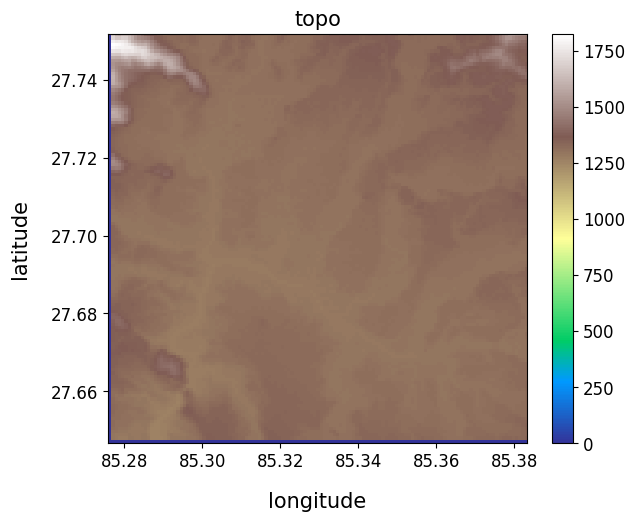

In [ ]:
%matplotlib inline
plot_layer('DEM/glo_90.dem',lay_type='topo')

The extracted coherence layer is stored within the coherence folder and with the interferometric date combination as its filename.

In [ ]:
!ls coherence

20180228_20180123	   20190211_20190106	      20200125_20191220
20180228_20180123.aux.xml  20190211_20190106.aux.xml  20200125_20191220.aux.xml
20180228_20180123.hdr	   20190211_20190106.hdr      20200125_20191220.hdr
20180228_20180123.vrt	   20190211_20190106.vrt      20200125_20191220.vrt
20180228_20180204	   20190211_20190118	      20200125_20200101
20180228_20180204.aux.xml  20190211_20190118.aux.xml  20200125_20200101.aux.xml
20180228_20180204.hdr	   20190211_20190118.hdr      20200125_20200101.hdr
20180228_20180204.vrt	   20190211_20190118.vrt      20200125_20200101.vrt
20180228_20180216	   20190211_20190130	      20200125_20200113
20180228_20180216.aux.xml  20190211_20190130.aux.xml  20200125_20200113.aux.xml
20180228_20180216.hdr	   20190211_20190130.hdr      20200125_20200113.hdr
20180228_20180216.vrt	   20190211_20190130.vrt      20200125_20200113.vrt
20180312_20180204	   20190223_20190118	      20200206_20200101
20180312_20180204.aux.xml  20190223_20190118.aux.xml  20200206_2

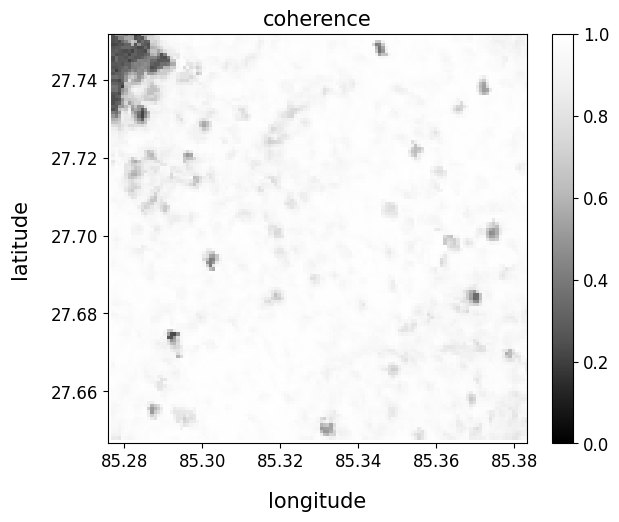

In [ ]:
%matplotlib inline
plot_layer(os.path.join('coherence', '20180228_20180123.vrt'))

The extracted incidence angle is stored within the incidenceAngle folder and with the interferometric date combination as its filename. Below we list the incidence Angle of the extent we used to ectract the product and visualiza it.

In [ ]:
!ls incidenceAngle

20180228_20180123	   20180228_20180123.hdr
20180228_20180123.aux.xml  20180228_20180123.vrt


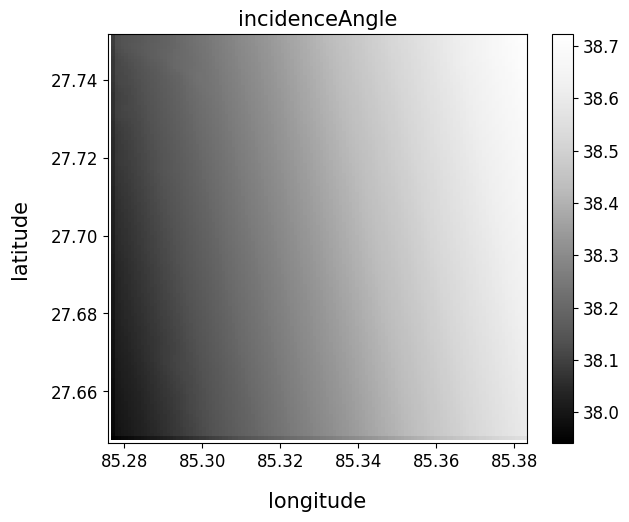

In [ ]:
%matplotlib inline
plot_layer(os.path.join('incidenceAngle', '20180228_20180123'))

Below we will list the unwrapped phase layer and visualize as map.

In [ ]:
!ls unwrappedPhase

20180228_20180123	       20190729_20190705.png
20180228_20180123.aux.xml      20190729_20190705.png.aux.xml
20180228_20180123.hdr	       20190729_20190705.vrt
20180228_20180123.png	       20190729_20190717
20180228_20180123.png.aux.xml  20190729_20190717.aux.xml
20180228_20180123.vrt	       20190729_20190717.hdr
20180228_20180204	       20190729_20190717.png
20180228_20180204.aux.xml      20190729_20190717.png.aux.xml
20180228_20180204.hdr	       20190729_20190717.vrt
20180228_20180204.png	       20190810_20190705
20180228_20180204.png.aux.xml  20190810_20190705.aux.xml
20180228_20180204.vrt	       20190810_20190705.hdr
20180228_20180216	       20190810_20190705.png
20180228_20180216.aux.xml      20190810_20190705.png.aux.xml
20180228_20180216.hdr	       20190810_20190705.vrt
20180228_20180216.png	       20190810_20190717
20180228_20180216.png.aux.xml  20190810_20190717.aux.xml
20180228_20180216.vrt	       20190810_20190717.hdr
20180312_20180204	       20190810_20190717.png
20180312_20

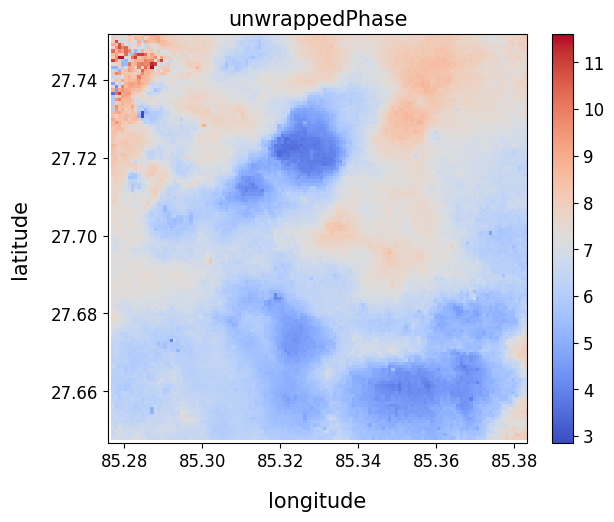

In [ ]:
%matplotlib inline
plot_layer(os.path.join('unwrappedPhase', '20180228_20180123.vrt'))

# 3. Run InSAR time series analysis using MintPy

MintPy, the Miami InSAR Timeseries software in Python, is a freely available package designed for InSAR time-series analysis. It specializes in processing stacks of unwrapped interferograms in either geographic or radar coordinates to generate ground displacement time-series. While MintPy is primarily tailored for stacks of interferograms processed with ISCE, it also offers support for interferograms processed with other InSAR processors like GAMMA, GMTSAR, SNAP, and ROI_PAC.

MintPy is available on Github from the following page: https://github.com/insarlab/MintPy

References: The detailed algorithms implemented in MintPy can be found in the following paper:

Yunjun, Z., Fattahi, H., Amelung, F. (2019), Small baseline InSAR time series analysis: Unwrapping error correction and noise reduction, Computers & Geosciences, 133, 104331, doi:10.1016/j.cageo.2019.104331


**You can run every step in smallbaselineApp.py with one call, using the command in the cell below**

**For the purposes of this tutorial, we will run each step separately**

We will run the steps:
- load_data
- modify_network
- reference_point
- quick_overview
- invert_network
- reference_date
- velocity
- google_earth

Skipped steps include:
- correct_troposphere
- correct_topography
- correct_unwrap_error
- correct_LOD
- correct_SET
- deramp
- hdfeos5
- residual_RMS

Skipped steps will also be skipped if running the entire smallbaselineApp in the cell below.

In [ ]:
!smallbaselineApp.py --help

usage: smallbaselineApp.py
       [-h]
       [--dir WORKDIR]
       [-g]
       [-H]
       [-v]
       [--plot]
       [--start STEP]
       [--end STEP]
       [--dostep STEP]
       [customTemplateFile]

Routine Time Series Analysis for Small Baseline InSAR Stack

positional arguments:
  customTemplateFile
    custom template with option settings.
    ignored if the default smallbaselineApp.cfg is input.

options:
  -h, --help
    show this help message and exit
  --dir WORKDIR, --work-dir WORKDIR
    work directory, (default: ./).
  -g
    generate default template (if it does not exist) and exit.
  -H
    print the default template file and exit.
  -v, --version
    print software version and exit
  --plot
    plot results [only] without running smallbaselineApp.

steps processing (start/end/dostep):
  Command line options for steps processing with names are chosen from the following list:
  
  ['load_data', 'modify_network', 'reference_point', 'quick_overview', 'correct_unwrap_e

## 3.1. Create Directory for MintPy

Define and go to the Mintpy work directory.

In [ ]:
mintpy_dir = os.path.join(work_dir, 'aria_mintpy')
if not os.path.isdir(mintpy_dir): os.makedirs(mintpy_dir)
os.chdir(mintpy_dir)
print('working directory is',os.getcwd())

out_dir = os.path.join(mintpy_dir, 'output_kmz_tif')
if not os.path.isdir(out_dir): os.makedirs(out_dir)
print('output directory is',out_dir)

working directory is /content/ICIMOD_Training_Kathmandu_Subsidence/aria_mintpy
output directory is /content/ICIMOD_Training_Kathmandu_Subsidence/aria_mintpy/output_kmz_tif


## 3.2. Define/Set up MintPy Configuration file

To configure the processing parameters for the smallbaselineApp.py, you need to use two configuration files. Running smallbaselineApp.py requires at least one configuration files to be present and properly set up.

https://github.com/insarlab/MintPy/blob/main/src/mintpy/defaults/smallbaselineApp.cfg

In [ ]:
# utils function
def write_config_file(out_file, CONFIG_TXT, mode='a'):
    """Write configuration files for MintPy to process ARIA sample products"""
    if not os.path.isfile(out_file) or mode == 'w':
        with open(out_file, "w") as fid:
            fid.write(CONFIG_TXT)
        print('write configuration to file: {}'.format(out_file))
    else:
        with open(out_file, "a") as fid:
            fid.write("\n" + CONFIG_TXT)
        print('add the following to file: \n{}'.format(CONFIG_TXT))

CONFIG_TXT = '''# vim: set filetype=cfg:
mintpy.load.processor      = aria  #[isce, aria, hyp3, gmtsar, snap, gamma, roipac], auto for isce
#---------interferogram datasets:
mintpy.load.unwFile        = ../stack/unwrapStack.vrt
mintpy.load.corFile        = ../stack/cohStack.vrt
mintpy.load.connCompFile   = ../stack/connCompStack.vrt
#---------geometry datasets:
mintpy.load.demFile        = ../DEM/glo_90.dem
mintpy.load.incAngleFile   = ../incidenceAngle/*.vrt
mintpy.load.azAngleFile    = ../azimuthAngle/*.vrt
mintpy.load.waterMaskFile  = ../mask/watermask.msk
mintpy.reference.lalo=auto
mintpy.reference.date = 20180123
mintpy.network.startDate       = 20180123
mintpy.network.endDate         = 20181231

'''
config_file = os.path.join(mintpy_dir, "aria_mintpy.txt")
write_config_file(config_file, CONFIG_TXT, mode='w')

write configuration to file: /content/ICIMOD_Training_Kathmandu_Subsidence/aria_mintpy/aria_mintpy.txt


## 3.3. Load Data

**Run the `load_data` step**

The output of the loading step is an "inputs" directory containing two HDF5 files:
- ifgramStack.h5: This file contains 6 dataset cubes (e.g. unwrapped phase, coherence, connected components etc.) and multiple metadata.  
- geometryGeo.h5: This file contains geometrical datasets (e.g., incidence/azimuth angle, masks, etc.).

In [ ]:
!smallbaselineApp.py {config_file} --dostep load_data

MintPy version 1.5.2, date 2023-08-09
--RUN-at-2023-08-10 04:54:31.417706--
Current directory: /content/ICIMOD_Training_Kathmandu_Subsidence/aria_mintpy
Run routine processing with smallbaselineApp.py on steps: ['load_data']
Remaining steps: ['modify_network', 'reference_point', 'quick_overview', 'correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: aria_mintpy
Go to work directory: /content/ICIMOD_Training_Kathmandu_Subsidence/aria_mintpy
copy default template file /usr/local/lib/python3.10/dist-packages/mintpy/defaults/smallbaselineApp.cfg to work directory
read custom template file: /content/ICIMOD_Training_Kathmandu_Subsidence/aria_mintpy/aria_mintpy.txt
update default template based on input custom template
    mintpy.load.processor: auto --> aria
    mintpy.load

In [ ]:
inputs_path = mintpy_dir+'/inputs'
!ls $inputs_path

aria_mintpy.txt  geometryGeo.h5  ifgramStack.h5  smallbaselineApp.cfg


## 3.4. Modify the Network

**Run the `modify_network` step**

- Identifies and excludes interferograms (i.e. affected by remaining coherence phase-unwrapping errors) before the network inversion

In [ ]:
!smallbaselineApp.py {config_file} --dostep modify_network

MintPy version 1.5.2, date 2023-08-09
--RUN-at-2023-08-10 04:54:46.959749--
Current directory: /content/ICIMOD_Training_Kathmandu_Subsidence/aria_mintpy
Run routine processing with smallbaselineApp.py on steps: ['modify_network']
Remaining steps: ['reference_point', 'quick_overview', 'correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: aria_mintpy
Go to work directory: /content/ICIMOD_Training_Kathmandu_Subsidence/aria_mintpy
read custom template file: /content/ICIMOD_Training_Kathmandu_Subsidence/aria_mintpy/aria_mintpy.txt
update default template based on input custom template
No new option value found, skip updating /content/ICIMOD_Training_Kathmandu_Subsidence/aria_mintpy/smallbaselineApp.cfg
read default template file: /content/ICIMOD_Training_Kathmandu_Subsiden

## 3.5. Plot the interferogram network

Running **plot_network.py** gives an overview of the network and the average coherence of the stack. The program creates multiple files as follows:
- `ifgramStack_coherence_spatialAvg.txt`: Contains interferogram dates, average coherence temporal and spatial baseline separation.
- `Network.pdf`: Displays the network of interferograms on time-baseline coordinates, colorcoded by avergae coherence of the interferograms.
- `CoherenceMatrix.pdf` shows the avergae coherence pairs between all available pairs in the stack.

read options from template file: smallbaselineApp.cfg
read temporal/spatial baseline info from file: inputs/ifgramStack.h5
open ifgramStack file: ifgramStack.h5
['coherenceSpatialAvg.txt'] exists and is newer than ['inputs/ifgramStack.h5', 'waterMask.h5'] --> skip.
coherenceSpatialAvg.txt already exists, read it directly
number of acquisitions: 90
number of interferograms: 261
shift all perp baseline by -24.44142723083496 to zero mean for plotting
--------------------------------------------------
number of interferograms marked as drop: 183
number of interferograms marked as keep: 78
number of acquisitions marked as drop: 61
['20190106', '20190118', '20190130', '20190211', '20190223', '20190307', '20190319', '20190331', '20190412', '20190424', '20190506', '20190518', '20190530', '20190611', '20190623', '20190705', '20190717', '20190729', '20190810', '20190822', '20190903', '20190915', '20190927', '20191009', '20191021', '20191102', '20191114', '20191126', '20191208', '20191220', '2020

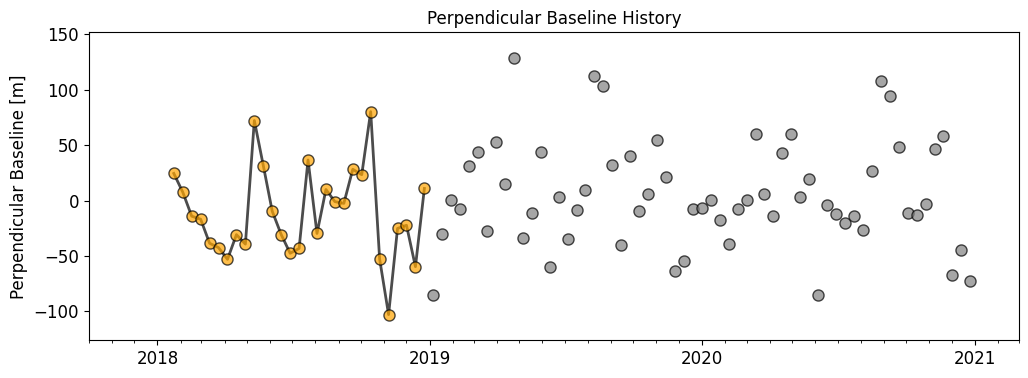

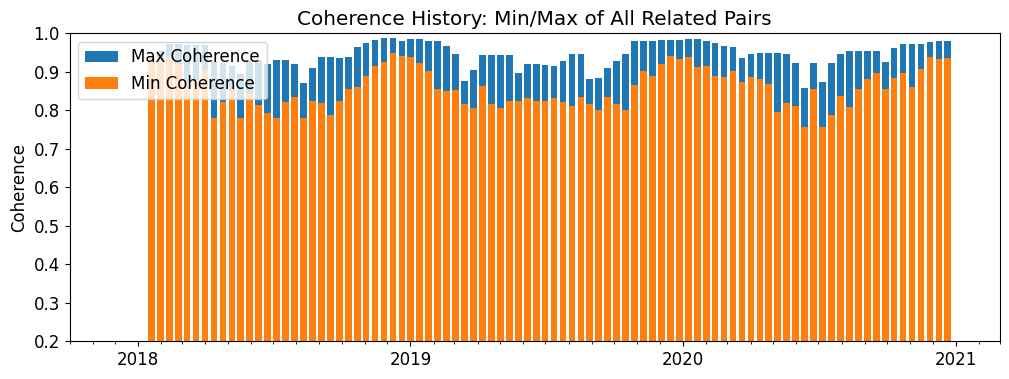

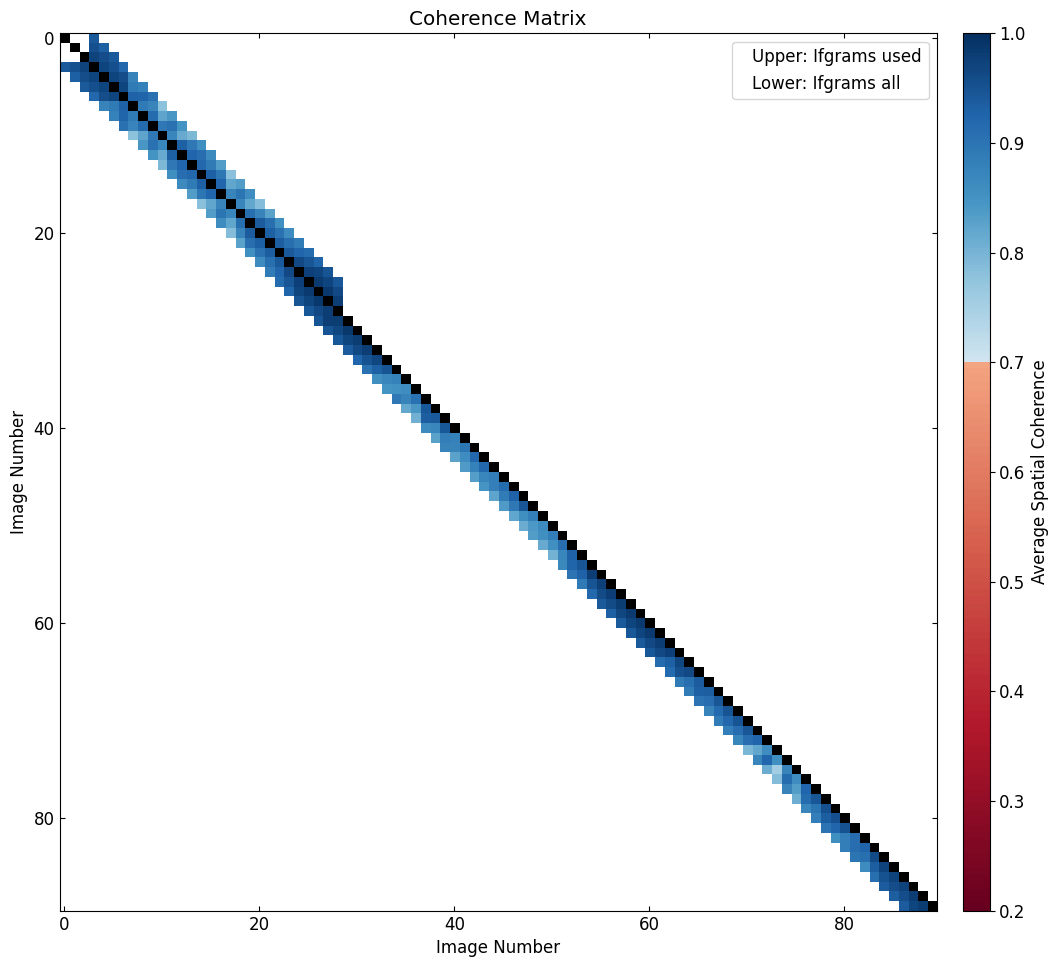

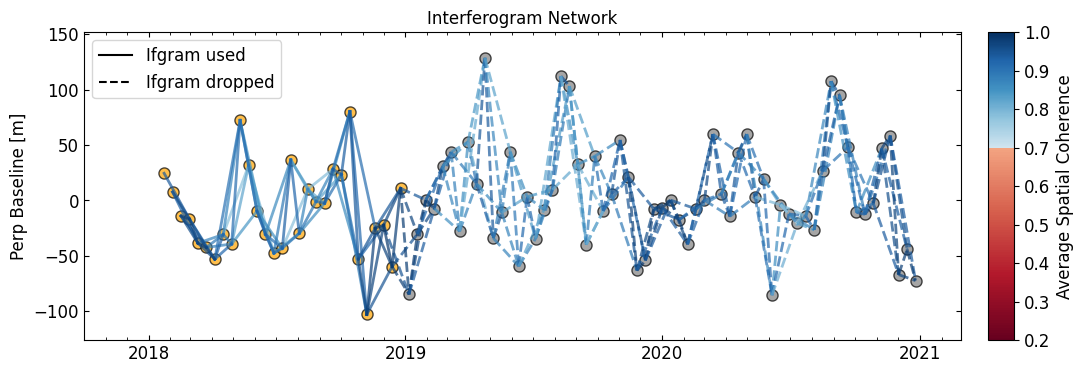

In [ ]:
plot_network.main('inputs/ifgramStack.h5 -t smallbaselineApp.cfg --figsize 12 4'.split())

<br>
<div class="alert alert-info">
<ol>
    <li><b>First Plot:</b> This plot shows the individual SAR images as circles plotted with time on the x-axis and perpendicular baseline $B_{\perp}$ on the y-axis. Orange Circles indicate images that were retained and Grey Circles show acquisitions that were dropped based on the coherence of the available interferograms. It can be seen that two images were removed from the stack.</li><br>
    <li><b>Second Plot:</b> This plots shows the coherence matrix. The main diagonal corresponds to the 132 SAR images in the stack. Off diagonal elements correspond to coherence values of formed from these SAR images. Colored matrix elements correspond to interferograms that were computed for this stack. White areas are missing interferograms. The color corresponds to the coherence. It can be seen that the coherence is high in most interferograms.</li><br>
    <li><b>Third Plot:</b> This plot provides a compressed view of the previous plot by presenting all interferograms used for a specific time step by their maximum and minimum coherence. Again, it can be seen that coherence overall is good for the analyzed area.</li><br>
    <li><b>Fourth Plot:</b> This plot shows the SAR images as circles (similar to the first plot) and adds interferograms as lines. E.g., an interferogram formed from the first and third SAR image would be plotted as a line connecting these two images. Dashed lines show interferograms that were dropped due to lower coherence.</li>
</ol>
</font>
</div>
<br>
<hr>

## 3.6. Set the Reference Point

**Run the `reference_point` step**

The interferometric phase is a relative observation by nature. The phases of each unwrapped interferogram are relative with respect to an arbitrary pixel. Therfore, we need to reference all interferograms to a common reference pixel.

The `reference_point` step selects a common reference pixel for the stack of interferograms. The default approach of MintPy is to choose a pixel with the highest spatial coherence in the stack. Other options include specifying the longitude and latitude of the desired reference pixel or the line and column number of the refence pixel.   

In [ ]:
!smallbaselineApp.py $config_path --dostep reference_point

MintPy version 1.5.2, date 2023-08-09
--RUN-at-2023-08-10 04:55:11.698757--
Current directory: /content/ICIMOD_Training_Kathmandu_Subsidence/aria_mintpy
Run routine processing with smallbaselineApp.py on steps: ['reference_point']
Remaining steps: ['quick_overview', 'correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Go to work directory: /content/ICIMOD_Training_Kathmandu_Subsidence/aria_mintpy
read default template file: /content/ICIMOD_Training_Kathmandu_Subsidence/aria_mintpy/smallbaselineApp.cfg


******************** step - reference_point ********************
Input data seems to be geocoded. Lookup file not needed.

generate_mask.py /content/ICIMOD_Training_Kathmandu_Subsidence/aria_mintpy/inputs/ifgramStack.h5 --nonzero -o /content/ICIMOD_Training_Kathmandu_Subsidence/ari

**Running the "reference_step" adds additional attributes "REF_X, REF_Y" and "REF_LON, REF_LAT" to the `ifgramStack.h5` file. To see the attributes of the file run `info.py`**

In [ ]:
!info.py $inputs_path/ifgramStack.h5 | egrep 'REF_'

  REF_LAT                      27.6904055905
  REF_LON                      85.37538251650001
  REF_X                        119
  REF_Y                        73


## 3.7. Inverting the Small Baseline network

**Run the `invert_network` step**

- Invert the network of differential unwrapped interferograms to estimate the time-series of unwrapped phase with respect to a reference acquisition date
- By default mintpy selects the first acquisition
- The estimated time-series is converted to distance change from radar to target and is provided in meters.

In [ ]:
!smallbaselineApp.py {config_file} --dostep invert_network

MintPy version 1.5.2, date 2023-08-09
--RUN-at-2023-08-10 04:55:14.045226--
Current directory: /content/ICIMOD_Training_Kathmandu_Subsidence/aria_mintpy
Run routine processing with smallbaselineApp.py on steps: ['invert_network']
Remaining steps: ['correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: aria_mintpy
Go to work directory: /content/ICIMOD_Training_Kathmandu_Subsidence/aria_mintpy
read custom template file: /content/ICIMOD_Training_Kathmandu_Subsidence/aria_mintpy/aria_mintpy.txt
update default template based on input custom template
No new option value found, skip updating /content/ICIMOD_Training_Kathmandu_Subsidence/aria_mintpy/smallbaselineApp.cfg
read default template file: /content/ICIMOD_Training_Kathmandu_Subsidence/aria_mintpy/smallbaselineApp.cfg


******************** step - invert_networ

## 3.8. Visualize InSAR time series analysis

The timeseries file contains three datasets, the time-series which is the interferometric range change for each acquisition relative to the reference acquisition, the "date" dataset which contains the acquisition date for each acquisition and the bperp dataset which contains the timeseries of the perpendicular baseline.

In [ ]:
!info.py timeseries.h5 --compact

******************** Basic File Info ************************
file name: /content/ICIMOD_Training_Kathmandu_Subsidence/aria_mintpy/timeseries.h5
file type: timeseries
coordinates : GEO

******************** Date Stat Info *************************
Start Date: 20180123
End   Date: 20181225
Number of dates  : 29
STD of datetimes : 0.27 years

******************** HDF5 File Structure ********************
Attributes in / level:
  ALOOKS                                     7
  ANTENNA_SIDE                               -1
  CENTER_LINE_UTC                            44541.0
  EARTH_RADIUS                               6337286.638938101
  END_DATE                                   20201226
  FILE_LENGTH                                126
  FILE_TYPE                                  timeseries
  HEADING                                    -12
  HEIGHT                                     693000.0
  LAT_REF1                                   27.646655608
  LAT_REF2                               

view.py timeseries.h5 --noverbose -m no


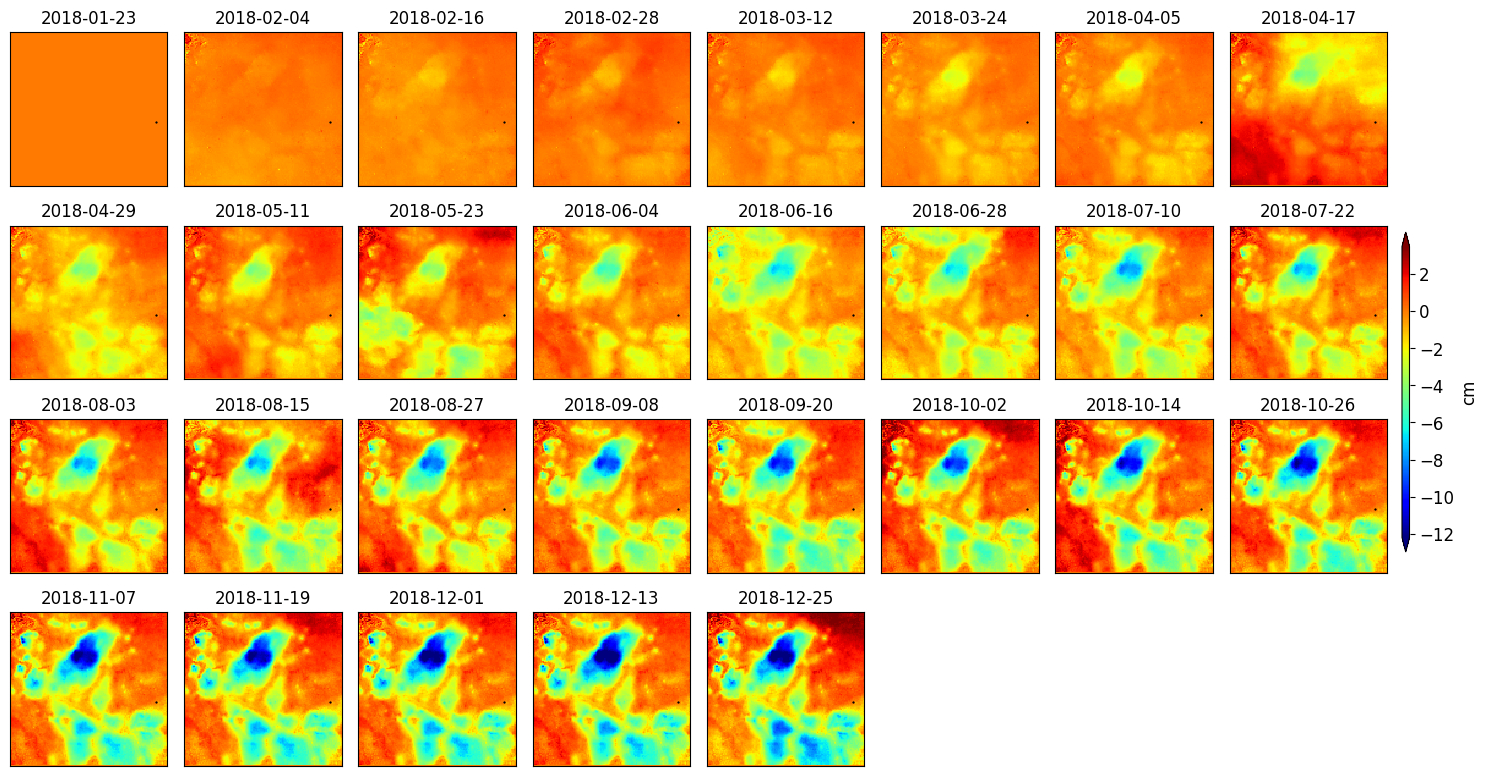

In [ ]:
ts='timeseries.h5'
%matplotlib inline
view.main(f'{ts} --noverbose -m no'.split())

## 3.9. Estimate The Long-Term Velocity Rate

**Run the `velocity` step**

The timeseries file contains three datasets:
- the `time-series` dataset, which is the interferometric range change for each acquisition relative to the reference acquisition
- the `date` dataset, which contains the acquisition date for each acquisition
- the `bperp` dataset, which contains the timeseries of the perpendicular baseline

The ground deformation caused by many geophysical or anthropogenic processes are linear at first order approximation. Therefore it is common to estimate the rate of the ground deformation which is the slope of linear fit to the time-series.

In [ ]:
outname_v= 'velocity_RAW.h5'
!timeseries2velocity.py {ts} -o {outname_v}

open timeseries file: timeseries.h5
--------------------------------------------------
dates from input file: 29
['20180123', '20180204', '20180216', '20180228', '20180312', '20180324', '20180405', '20180417', '20180429', '20180511', '20180523', '20180604', '20180616', '20180628', '20180710', '20180722', '20180803', '20180815', '20180827', '20180908', '20180920', '20181002', '20181014', '20181026', '20181107', '20181119', '20181201', '20181213', '20181225']
--------------------------------------------------
using all dates to calculate the time function
--------------------------------------------------
estimate deformation model with the following assumed time functions:
    polynomial : 1
    periodic   : []
    stepDate   : []
    polyline   : []
    exp        : {}
    log        : {}
add/update the following configuration metadata:
['startDate', 'endDate', 'excludeDate', 'polynomial', 'periodic', 'stepDate', 'exp', 'log', 'uncertaintyQuantification', 'timeSeriesCovFile', 'bootstra

run view.py in MintPy version 1.5.2, date 2023-08-09
input file is velocity file: /content/ICIMOD_Training_Kathmandu_Subsidence/aria_mintpy/velocity_RAW.h5 in float32 format
file size in y/x: (126, 129)
input dataset: "['velocity']"
turning glob search OFF for velocity file
num of datasets in file velocity_RAW.h5: 5
datasets to exclude (0):
[]
datasets to display (1):
['velocity']
data   coverage in y/x: (0, 0, 129, 126)
subset coverage in y/x: (0, 0, 129, 126)
data   coverage in lat/lon: (85.275799223, 27.751655566, 85.38329918000001, 27.646655608000003)
subset coverage in lat/lon: (85.275799223, 27.751655566, 85.38329918000001, 27.646655608000003)
------------------------------------------------------------------------
colormap: jet
initiate cartopy map projection: PlateCarree
figure title: velocity_velocity
read mask from file: maskTempCoh.h5
reading data ...
masking data
data    range: [-16.812498, 2.9008117] cm/year
display range: [-16.812498, 2.9008117] cm/year
reading DEM: geome

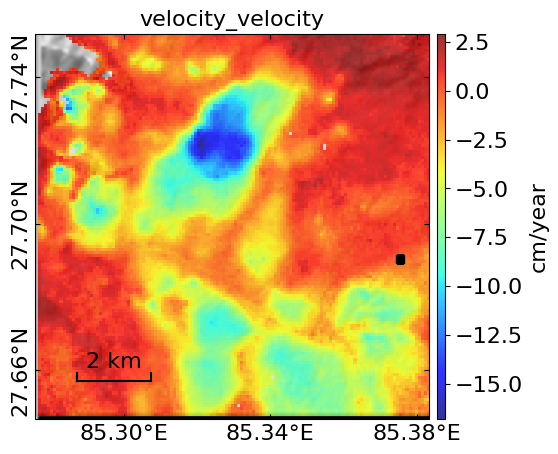

In [ ]:
%matplotlib inline
opt = '--dem ./inputs/geometryGeo.h5 --shade-exag 0.05 --dem-nocontour --lalo-label --ylabel-rot 90 --figsize 7 5'
view.main(f'{outname_v} velocity -u cm {opt}'.split())

<div class="alert alert-info">
<b>Note :</b>
Negative values indicates that target is moving away from the radar (i.e., Subsidence in case of vertical deformation).
Positive values indicates that target is moving towards the radar (i.e., uplift in case of vertical deformation).
    The line of sight (LOS) for this descending Sentinel-1 track is up and east from ground to radar.
</div>

# 4. Error analysis (signal vs noise)

Uncertainty of the ground displacement products derived from InSAR time-series, depends on the quality of the inversion of the stack of interferograms and the accuracy in separating the ground displacement from other components of the InSAR data. Therefore the definition of signal vs noise is different at the two main steps in MintPy:  

1) During the inversion:
    At this step all systematic components of the interferometric phase (e.g., ground displacement, propagation delay, geometrical residuals caused by DEM or platform's orbit inaccuracy) are considered signal, while the interferometric phase decorrelation, phase unwrapping error and phase inconsistency are considered noise.
    
2) After inversion: the ground displacement component of the time-serieses is signal, and everything else (including the propagation delay and geometrical residuals) are considered noise

Therefore we first discuss the possible sources of error during the inversion and the existing ways in MintPy to evaluate the quality of inversion and to improve the uncertainty of the inversion. Afterwards we explain the different components of the time-series and the different processing steps in MintPy to separate them from ground displacement signal.  


## 4.1. Quality of the inversion

The main sources of noise during the time-series inversion includes decorrelation, phase unwrapping error and the inconsistency of triplets of interferofgrams. Here we mainly focus on the decorrelation errors. We show the existing quantities in MintPy to evaluate decorrelation.

### 4.1.1. Average spatial coherence

Mintpy computes temporal average of spatial coherence of the entire stack as a potential ancillary measure to choose reliable pixels after time-series inversion.

view.py avgSpatialCoh.h5 --noverbose


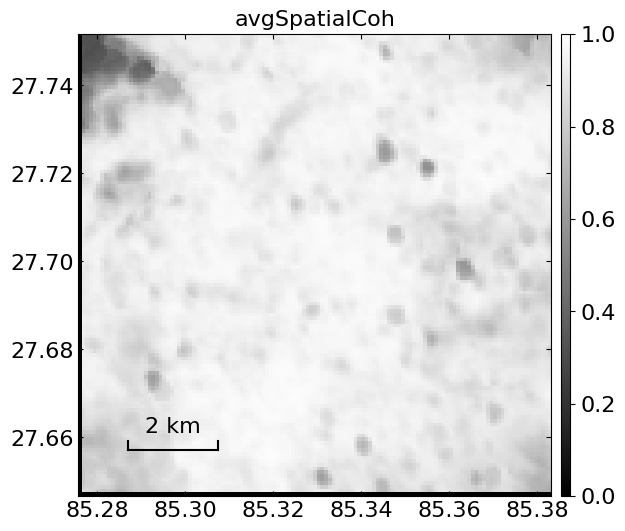

In [ ]:
%matplotlib inline
view.main('avgSpatialCoh.h5 --noverbose'.split())

### 4.1.2. Temporal coherence

In addition to timeseries.h5 which contains the time-series dataset, invert_network produces other quantities, which contain metrics to evaluate the quality of the inversion including temporalCoherence.h5. Temporal coherence represents the consistency of the timeseries with the network of interferograms.

Temporal coherence varies from 0 to 1. Pixels with values closer to 1 are considered reliable and pixels with values closer to zero are considered unreliable. For a dense network of interferograms, a threshold of 0.7 may be used (Yunjun et al, 2019).

view.py temporalCoherence.h5 --noverbose


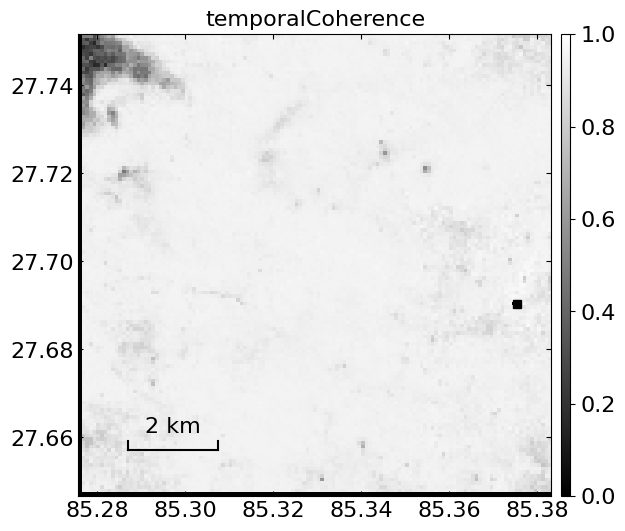

In [ ]:
%matplotlib inline
view.main('temporalCoherence.h5 --noverbose'.split())

## 4.2. Velocity error analysis

The estimated velocity also comes with an expression of unecrtainty which is simply based on the goodness of fit while fitting a linear model to the time-series. This quantity is saved in "velocity.h5" under the velocityStd dataset.

run view.py in MintPy version 1.5.2, date 2023-08-09
input file is velocity file: /content/ICIMOD_Training_Kathmandu_Subsidence/aria_mintpy/velocity_RAW.h5 in float32 format
file size in y/x: (126, 129)
input dataset: "['velocityStd']"
turning glob search OFF for velocity file
num of datasets in file velocity_RAW.h5: 5
datasets to exclude (0):
[]
datasets to display (1):
['velocityStd']
data   coverage in y/x: (0, 0, 129, 126)
subset coverage in y/x: (0, 0, 129, 126)
data   coverage in lat/lon: (85.275799223, 27.751655566, 85.38329918000001, 27.646655608000003)
subset coverage in lat/lon: (85.275799223, 27.751655566, 85.38329918000001, 27.646655608000003)
------------------------------------------------------------------------
colormap: jet
initiate cartopy map projection: PlateCarree
figure title: velocity_velocityStd
read mask from file: maskTempCoh.h5
reading data ...
masking data
data    range: [0.0, 0.762151] cm/year
display range: [0.0, 0.762151] cm/year
reading DEM: geometryGeo.

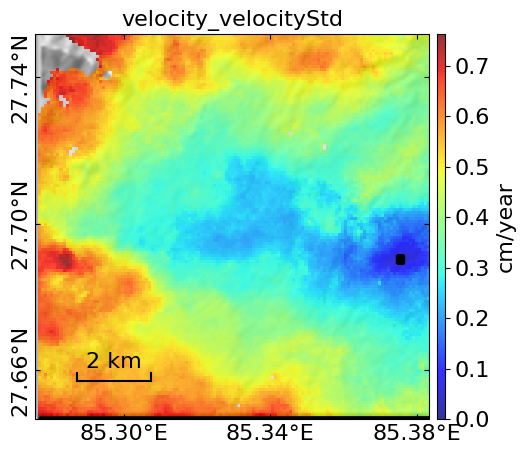

In [ ]:
%matplotlib inline
opt = '--dem ./inputs/geometryGeo.h5 --shade-exag 0.05 --dem-nocontour --lalo-label --ylabel-rot 90 --figsize 7 5'
view.main(f'{outname_v} velocityStd -u cm {opt}'.split())

# 5. Compare InSAR time-series with GPS time-series in LOS direction

MintPy's analysis is independent of GPS observations. This allows validating InSAR products with GPS data when they are available. For this purpose MintPy automatically downloads GPS data over the region of interest from Nevada Geodetic Laboratory at University of Nevada, Reno.

- http://geodesy.unr.edu/NGLStationPages/gpsnetmap/GPSNetMap.html
- http://geodesy.unr.edu/NGLStationPages/DataHoldings.txt


To download the GPS data, project the components to InSAR LOS direction and plot them on the InSAR velocity map one can use the following command:

In order to display the GPS station names on the plot add --gps-label to the plot.

run view.py in MintPy version 1.5.2, date 2023-08-09
input file is velocity file: /content/ICIMOD_Training_Kathmandu_Subsidence/aria_mintpy/velocity_RAW.h5 in float32 format
file size in y/x: (126, 129)
input dataset: "['velocity']"
turning glob search OFF for velocity file
num of datasets in file velocity_RAW.h5: 5
datasets to exclude (0):
[]
datasets to display (1):
['velocity']
data   coverage in y/x: (0, 0, 129, 126)
subset coverage in y/x: (0, 0, 129, 126)
data   coverage in lat/lon: (85.275799223, 27.751655566, 85.38329918000001, 27.646655608000003)
subset coverage in lat/lon: (85.275799223, 27.751655566, 85.38329918000001, 27.646655608000003)
------------------------------------------------------------------------
colormap: jet
initiate cartopy map projection: PlateCarree
figure title: velocity_velocity
read mask from file: maskTempCoh.h5
reading data ...
masking data
data    range: [-16.812498, 2.9008117] cm/year
display range: [-16.812498, 2.9008117] cm/year
display data in tr

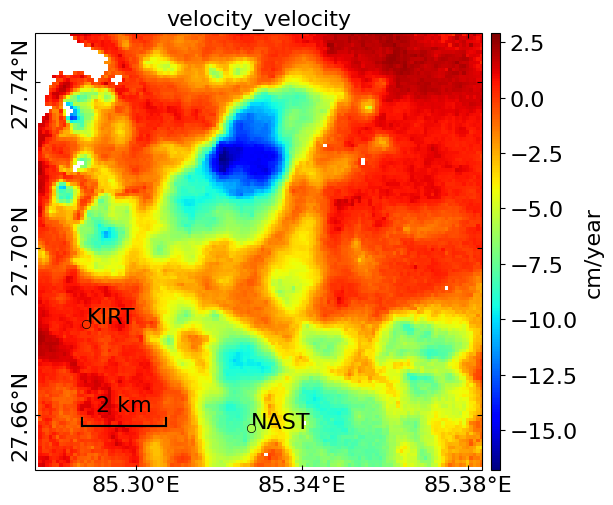

In [ ]:
opt = '--show-gps --ref-gps KIRT --gps-comp enu2los --gps-label '
opt += '--lalo-label --ylabel-rot 90 --figsize 6 6 '
view.main(f'velocity_RAW.h5 velocity {opt}'.split())

# 5. Export output

## 5.1. Extract displacement at points

To export displacement data for any specific location, provide the location name along with its longitude and latitude. After that, execute the following code, which will export the displacement data to a CSV file.

In [ ]:
# file in geo coordinates
geom_file = None
print(f'read from file: {ts}')

location_name= ['Lazimpat', 'Kalimati', 'Patan','Sano Bharang',"New_baneshwor"]
my_lon=[ 85.320254,85.290321,85.325961,85.285682,85.336996]
my_lat=[27.719888,27.705809,27.671760,27.720620,27.690337]

# create an empty dataframe
df = pd.DataFrame({})

# loop through each column and add it to the dataframe
i=1
for col in location_name:
    dates, dis, dis_std = ut.read_timeseries_lalo(lat=my_lat[i-1], lon=my_lon[i-1], ts_file=ts, lookup_file=geom_file)
    df.loc[:, col] = pd.Series(dis, dtype=float)
    i=i+1

df['Date']=dates
print(df.head)
# export the DataFrame as a CSV file
filename=out_dir+'/SBAS_mintpy_displacement_my_points'+'.csv'
df.to_csv(filename, index=False)

read from file: timeseries.h5
input lat / lon: 27.719888 / 85.320254
corresponding y / x: 38 / 53
input lat / lon: 27.705809 / 85.290321
corresponding y / x: 55 / 17
input lat / lon: 27.67176 / 85.325961
corresponding y / x: 95 / 60
input lat / lon: 27.72062 / 85.285682
corresponding y / x: 37 / 11
input lat / lon: 27.690337 / 85.336996
corresponding y / x: 73 / 73
<bound method NDFrame.head of     Lazimpat  Kalimati     Patan  Sano Bharang  New_baneshwor       Date
0   0.000000  0.000000  0.000000      0.000000       0.000000 2018-01-23
1  -0.001805 -0.001560 -0.004967     -0.001237      -0.001366 2018-02-04
2  -0.014143 -0.007828 -0.006160     -0.003034      -0.004265 2018-02-16
3  -0.009695 -0.001518 -0.006566      0.003920       0.001920 2018-02-28
4  -0.015989 -0.005183 -0.009726     -0.002235      -0.004284 2018-03-12
5  -0.027000 -0.013250 -0.016797     -0.008239      -0.008398 2018-03-24
6  -0.027818 -0.011499 -0.013174     -0.007194      -0.006306 2018-04-05
7  -0.041509 -0.00

## 5.2. Export maps as kmz and tif

To export the velocity map as a KML file and explore using Google Earth using following code. Additionally, output can be exported as a georeferenced TIFF file, which can be to visualize using various GIS tools.



In [ ]:
# save mask connected component, mastemporal coherence, average spatial coherence, temporal coherence
!save_gdal.py maskConnComp.h5 --of GTIFF -o $out_dir/maskConnComp.tif
!save_gdal.py maskTempCoh.h5 --of GTIFF -o $out_dir/maskTempCoh.tif
!save_gdal.py avgSpatialCoh.h5 --of GTIFF -o $out_dir/avgSpatialCoh.tif
!save_gdal.py temporalCoherence.h5 --of GTIFF -o $out_dir/temporalCoherence.tif

!save_gdal.py velocity_RAW.h5  --of GTIFF -o $out_dir/velocity_RAW.tif
!save_kmz.py velocity_RAW.h5 -o $out_dir/velocity_RAW.kmz

read data from file: maskConnComp.h5
/usr/local/lib/python3.10/dist-packages/mintpy/save_gdal.py:57: UserWarning: No EPSG or UTM_ZONE metadata found! Assume EPSG = 4326 (WGS84) and continue.
  warnings.warn(msg)
convert data from boolean to uint8, as GDAL does not support boolean
initiate GDAL driver: GeoTIFF
create raster band:
  raster row / column number: 126, 129
  raster data type: 1 (uint8)
set transform info: (85.275799223, 0.000833333, 0, 27.751655566, 0, -0.000833333)
set projection as: EPSG 4326
write data to raster band
finished writing to /content/ICIMOD_Training_Kathmandu_Subsidence/aria_mintpy/output_kmz_tif/maskConnComp.tif
read data from file: maskTempCoh.h5
/usr/local/lib/python3.10/dist-packages/mintpy/save_gdal.py:57: UserWarning: No EPSG or UTM_ZONE metadata found! Assume EPSG = 4326 (WGS84) and continue.
  warnings.warn(msg)
convert data from boolean to uint8, as GDAL does not support boolean
initiate GDAL driver: GeoTIFF
create raster band:
  raster row / column n

<div class="alert alert-info">
<b>Note :</b>
This exercise excludes atmospheric correction ,DEM error correction and phase unwrappping error.
Users are advised to refer to the Jupyter notebook provided at the beginning of this notebook to learn how to implement these corrections.
</div>

 -------------------------------------------------------------------- GOOD LUCK ---------------------------------------------------------------------------